# Relion comparison

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [6]:
import numpy as np
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10

from src.utils import volume_fourier, mip_x, mip_z, create_mask
from src.projection import project
#from src.interpolate import *

from external.pyem.pyem import star
import mrcfile

### The volume

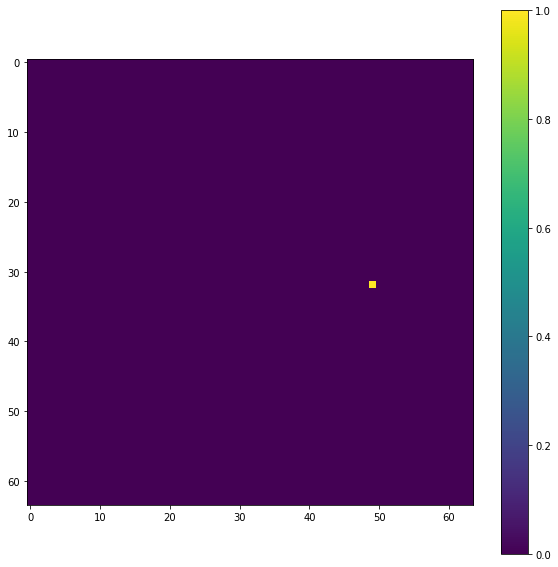

In [35]:
nx = 64
dx = 0.2

vol = np.zeros([nx,nx,nx])
vol[32,49,32] = 1

vol_relion = np.zeros([nx,nx,nx])
vol_relion[32,32,49] = 1

mip_x(vol_relion); plt.colorbar()


### Relion projection

Write the volume to file so it can be processed by Relion

In [21]:
with mrcfile.new('../data/pointmass.mrc', overwrite=True) as mrc:
    mrc.set_data(vol_relion.astype(np.float32))

Then start the Relion Singularity instance on a job on the cluster, go to the data directory and run:

```~/project/relion/build/bin/relion_project --i pointmass.mrc --o relion_proj.mrc --ctf false```

Then load the result:

In [22]:
with mrcfile.open('../data/relion_proj.mrc') as mrc:
    proj_relion = mrc.data

In [23]:
proj_relion

array([[-6.6760113e-04, -1.2940775e-03,  1.3929527e-03, ...,
         1.2579216e-03,  1.7696852e-03,  2.0645126e-03],
       [ 1.4039566e-04,  1.5013625e-03, -1.6246252e-03, ...,
         1.8640747e-04, -2.8543640e-03, -1.2160420e-03],
       [-1.2032978e-03,  2.3206619e-04, -5.7221467e-05, ...,
        -6.1363284e-04,  2.5211524e-03,  1.7817277e-03],
       ...,
       [ 7.3928566e-04, -7.3455019e-05, -4.3645740e-04, ...,
         1.6507952e-04, -1.8391514e-03, -1.6346511e-03],
       [-1.2032978e-03,  2.3206619e-04, -5.7221467e-05, ...,
        -6.1363284e-04,  2.5211524e-03,  1.7817277e-03],
       [ 1.4039566e-04,  1.5013625e-03, -1.6246252e-03, ...,
         1.8640747e-04, -2.8543640e-03, -1.2160420e-03]], dtype=float32)

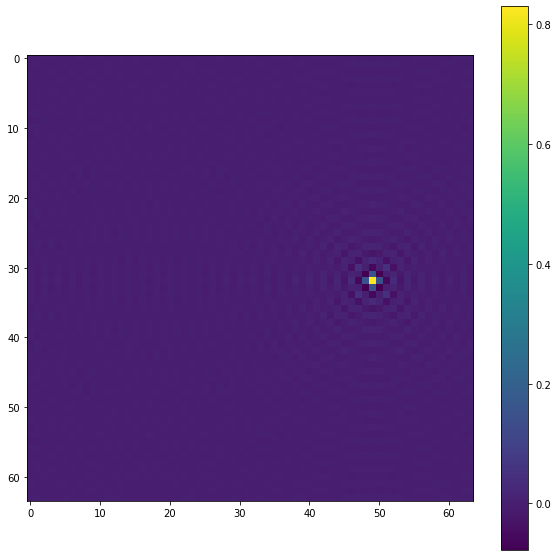

In [34]:
plt.imshow(proj_relion); plt.colorbar()

### My projection

In [36]:
# Pixel size - here we multiply by 64/66 to match the 'effective pixel size' in pyem, 
# where the image is padded with 3 additional rows/columns (in addition to the padding)
pixel_size = 1 #star.calculate_apix(p) * 64.0/66.0

f3d, X, Y, Z = volume_fourier(np.fft.ifftshift(vol), pixel_size)

#mymask = create_mask(X,Y,Z, (0,0,0), np.max(X))
#f3d = f3d * mymask

x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# IMPORTANT: do not make this a Jax array
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

angles = [0,0,0] # third angle is rotation around the first z axis
shifts = [0.0, 0.0]

In [40]:
f2d, coords_slice = project(f3d, x_grid, y_grid, z_grid, angles, shifts, 'tri', None)
f2d = f2d.reshape(f3d.shape[0], f3d.shape[1])
#f2d = np.fft.fftshift(f2d)
proj = np.real(np.fft.fftshift(np.fft.ifftn(f2d)))

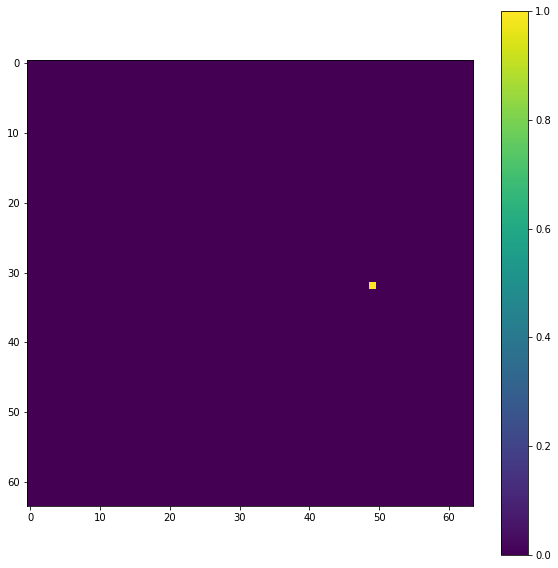

In [41]:
plt.imshow(proj); plt.colorbar()